#LSTM NN con database FASHION MNIST

*Long-Short Term Memory* neural network sviluppata in TensorFlow versione 1.x, su database FASHION MNIST.

In questo notebook lo scopo è testare il modello con un altro database; per spiegazioni più dettagliate, guardare la versione corrispondente al modello su database MNIST.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
from tensorflow import keras as ks

#tf.reset_default_graph()

#RNN Cells and additional RNN operations.
#contrib è un modulo "sperimentale" in TF 1.x; aggiunto in TF 2.x
#from tensorflow.contrib import rnn
#Preferisco utilizzare keras (come built-in in TensorFlow) che le strutture in tf

print(tf.__version__)

1.15.2


In [3]:
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax

#Per interoperabilità di Python 2/3
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from numpy import array
from numpy import argmax

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix
#Per data visualization
import seaborn as sns

import time

print("Done")

Done


##Definizione metodi

In [4]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

print("Done")

Done


In [5]:
class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

print("Done")

Done


##Import database

In [6]:
#Import del database MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#Struttura dati nel database
print("Numero elementi e dimensione immagini in train set: " + str(train_images.shape))
print("Numero elementi e dimensione immagini in test set: " + str(test_images.shape))
print("Numero elementi label in train set: " + str(len(train_labels)))
print("Numero elementi label in test set: " + str(len(test_labels)))
print("Tipo di struttura del train set: " + str(type(train_images)) + ", composto da " + str(type(train_images[0])))
print("Tipo di struttura del label set: " + str(type(train_labels)) + ", composto da " + str(type(train_labels[0])))
print("Le etichette sono interi; valore più piccolo: " + str(np.amin(train_labels)) + ", valore più grande: " + str(np.amax(train_labels)))

4423680/4422102 [==============================] - 0s 0us/step
Numero elementi e dimensione immagini in train set: (60000, 28, 28)
Numero elementi e dimensione immagini in test set: (10000, 28, 28)
Numero elementi label in train set: 60000
Numero elementi label in test set: 10000
Tipo di struttura del train set: <class 'numpy.ndarray'>, composto da <class 'numpy.ndarray'>
Tipo di struttura del label set: <class 'numpy.ndarray'>, composto da <class 'numpy.uint8'>
Le etichette sono interi; valore più piccolo: 0, valore più grande: 9


##Preprocessing

In [7]:
#Preprocessing dei dati
#Scalo i valori nel range tra 0 e 1
train_images = train_images / 255.0

test_images = test_images / 255.0

print("Done")

Done


##Costanti

In [0]:
#Costanti
batch_size = 256
num_units = batch_size
time_steps = 28
n_features = 28

#Unit in first layer
num_units1 = batch_size
#Unit in second layer
num_units2 = (int)(num_units1 / 2)

num_batches = int(len(train_labels) / batch_size)

n_classes = 10
act = 'softmax'

opt = 'adam'

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

##Reshape

In [0]:
train_images = train_images.reshape(-1, time_steps, n_features)

test_images = test_images.reshape(-1, time_steps, n_features)

#Modello

##Build

In [10]:
modelLSTM = ks.Sequential()

modelLSTM.add(LSTM(num_units1, input_shape=(time_steps, n_features), activation='relu', return_sequences='true'))
modelLSTM.add(LSTM(num_units2, activation='relu'))
modelLSTM.add(Dense(n_classes, activation=act))

print("Done")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Done


##Compile

In [11]:
modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 256)           291840    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 490,250
Trainable params: 490,250
Non-trainable params: 0
_________________________________________________________________


##Training

Utilizzando la CPU, il tempo utilizzato con questo modello impiega qualche minuto; utilizzo quindi la GPU.

In [12]:
#Batch size should be (at most) the same number of hidden cells
time_callback = TimeHistory()
hist = modelLSTM.fit(train_images, train_labels, batch_size = batch_size, validation_data=(test_images, test_labels), 
                     epochs=5, callbacks=[time_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 31s 514us/sample - loss: 0.8152 - acc: 0.6996 - val_loss: 0.6093 - val_acc: 0.7739
Epoch 2/5
60000/60000 [==============================] - 28s 471us/sample - loss: 0.4808 - acc: 0.8234 - val_loss: 0.4735 - val_acc: 0.8195
Epoch 3/5
60000/60000 [==============================] - 28s 460us/sample - loss: 0.3993 - acc: 0.8523 - val_loss: 0.4145 - val_acc: 0.8432
Epoch 4/5
60000/60000 [==============================] - 28s 460us/sample - loss: 0.3639 - acc: 0.8651 - val_loss: 0.3702 - val_acc: 0.8610
Epoch 5/5
60000/60000 [==============================] - 27s 458us/sample - loss: 0.3347 - acc: 0.8760 - val_loss: 0.3529 - val_acc: 0.8711


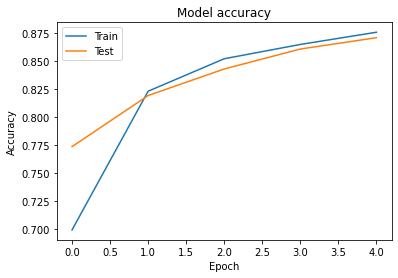

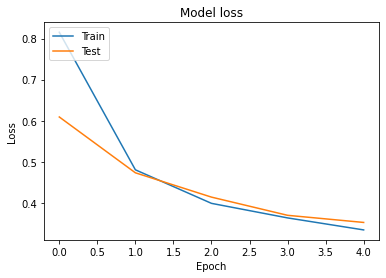

Time per epoch: [30.858408212661743, 28.27214503288269, 27.61535358428955, 27.587040424346924, 27.484313488006592]
Total time: 141.8172607421875


In [13]:
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

##Matrice di confusione

Genero la matrice di confusione sul test set.

In [14]:
#Necessito di un array con tutte le labels, ho già class_names

test_predictions = modelLSTM.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = class_names, 
                          columns = class_names)

[[854   9  15  35   4   1  75   0   7   0]
 [  2 969   2  21   1   0   4   0   1   0]
 [ 20   1 819  16  87   1  51   0   5   0]
 [ 24   8  12 891  28   0  35   0   2   0]
 [  1   1 125  30 799   1  40   0   3   0]
 [  0   0   0   2   0 987   0   8   1   2]
 [186   6 108  27  99   0 561   0  13   0]
 [  0   0   0   0   0  54   0 909   0  37]
 [  3   1   7   6   2   4   0   4 973   0]
 [  0   0   0   0   0  19   0  31   1 949]]


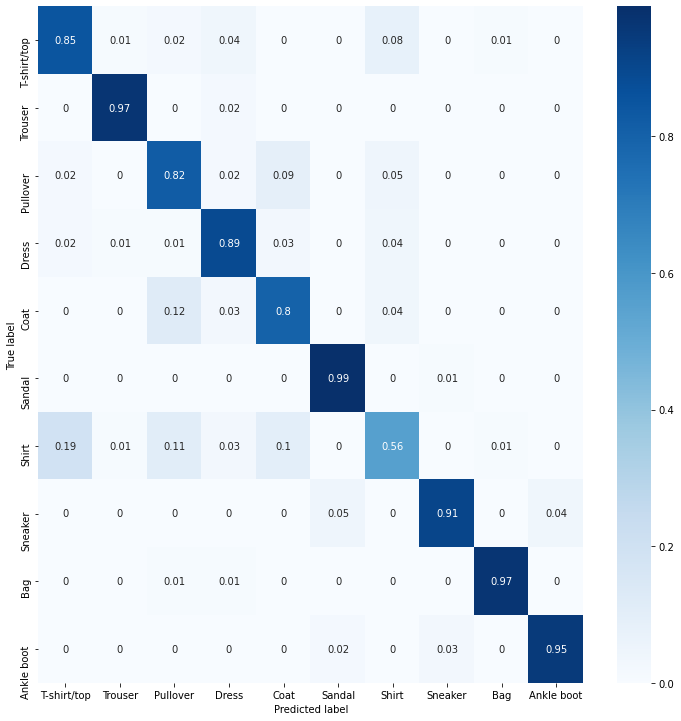

In [15]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#Predizioni

In [16]:
predictions = modelLSTM.predict(test_images)

print("Done")

Done


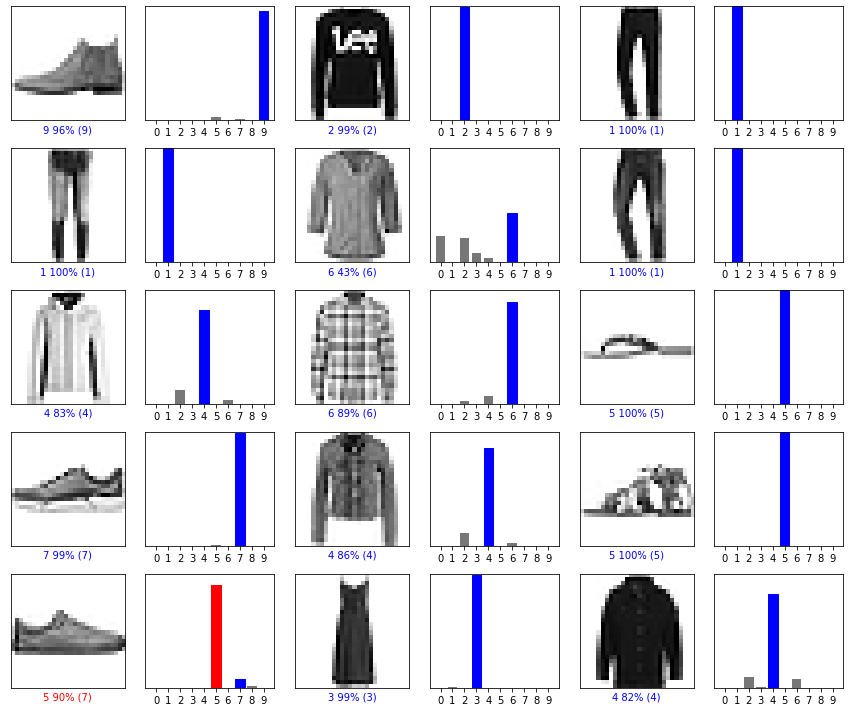

In [17]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()